In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch 
from torchvision import transforms , models 
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
device = ("cuda" if torch.cuda.is_available() else "cpu")
import cv2
from google.colab.patches import cv2_imshow

In [3]:
content_dir = "/content/drive/MyDrive/CV/florence.jpeg"
style_dir = "/content/drive/MyDrive/CV/biker.png"

In [4]:
def remove_gradients(model):
  '''
  Detach gradients from each one of the model's parameters.
  '''
  for p in model.parameters():
    p.requires_grad = False
  model.to(device)
  return model


In [5]:

model = models.vgg19(pretrained=True).features
model = remove_gradients(model)

def model_activations(input,model, layers):

    features = {}
    image = input.unsqueeze(0)
    for name,layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    
    return features

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [6]:
def transformation(feature, size, normalizer):
  '''
  size = 300
  normalize = (0.5,0.5,0.5),(0.5,0.5,0.5)
  '''

  transform = transforms.Compose([transforms.Resize(size),
                              transforms.ToTensor(),
                              transforms.Normalize(normalizer, normalizer)])
  transformed = transform(feature).to(device)
  return transformed 
  

In [7]:
size = 1000
normalizer = (0.5,0.5,0.5)
normalizer1 = (0.3,0.3,0.3)
normalizer2 = (0.4,0.4,0.4)
normalizer3 = (0.5,0.6,0.4)

content = Image.open(content_dir).convert("RGB")
print(content)
content = transformation(content, size, normalizer)
print("Content shape => ", content.shape)
style = Image.open(style_dir).convert("RGB")
style = transformation(style, size, normalizer)
print(style.shape)

<PIL.Image.Image image mode=RGB size=1200x799 at 0x7FEA3C89D880>
Content shape =>  torch.Size([3, 1000, 1501])
torch.Size([3, 1000, 1000])


In [8]:

def image_conversion(image,normalizer):
    image = image.to("cpu").clone().detach()
    squeezed = image.numpy().squeeze()
    normalized_img = np.array(normalizer) + squeezed.transpose(1,2,0)*np.array(normalizer)
    return np.clip(normalized_img,0,1)


In [9]:
print(cv2.__version__)

4.6.0


In [10]:
def gram_matrix(imgfeature):
    _,dimension,height,width = imgfeature.size()
    imgfeature = imgfeature.reshape(dimension,height*width) #view
    gram_matrix = imgfeature @ torch.transpose(imgfeature, 0, 1) # @ is matrix multiplication
    return gram_matrix


target = content.clone().requires_grad_(True).to(device)

#set device to cuda if available
print("device = ",device)


layers = {
'0' : 'conv1_1',
'5' : 'conv2_1',
'10': 'conv3_1',
'19': 'conv4_1',
'21': 'conv4_2',
'28': 'conv5_1'
}
style_features = model_activations(style,model, layers)
content_features = model_activations(content,model, layers)

style_weight_measures = {"conv1_1" : 1, 
                 "conv2_1" : 0.8,
                 "conv3_1" : 0.6,
                 "conv4_1" : 0.4,
                 "conv5_1" : 0.2}


def build_style_gram_matrixes (style_features):
  final_dict = {}
  for layer in style_features:
    final_dict[layer] = gram_matrix(style_features[layer])
  return final_dict                             

content_weight = 10
style_weight = 50e8

print_frequency = 150
epochs = 4000
optimizer = torch.optim.Adam([target],lr=0.007)

device =  cuda


In [11]:
style_gram_matrixes = build_style_gram_matrixes(style_features)

In [12]:
def loss_fn(content_features, style_weight_measures):
  content_loss = torch.mean(torch.pow(content_features['conv4_2']-target_features['conv4_2'],2))
  style_loss = 0
  for layer in style_weight_measures:
      style_gram = style_gram_matrixes[layer]
      target_gram_matrixes = target_features[layer]
      dimensions = torch.tensor(target_gram_matrixes.shape)
      denominator = torch.prod(dimensions, 0).double()
      target_gram_matrixes = gram_matrix(target_gram_matrixes)
      temp_loss = (style_weight_measures[layer]*torch.mean(torch.pow(target_gram_matrixes-style_gram,2)))
      style_loss += temp_loss/denominator
  
  total_loss = content_weight*content_loss + style_weight*style_loss
  return total_loss


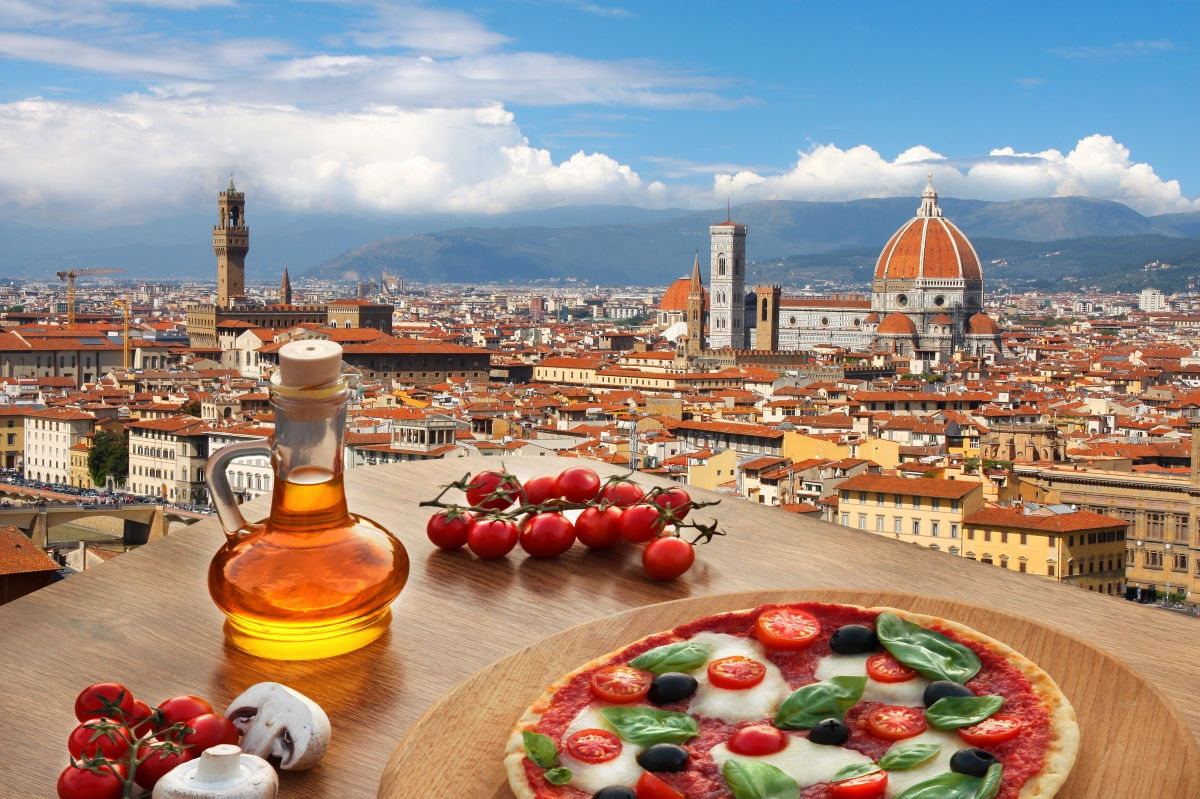

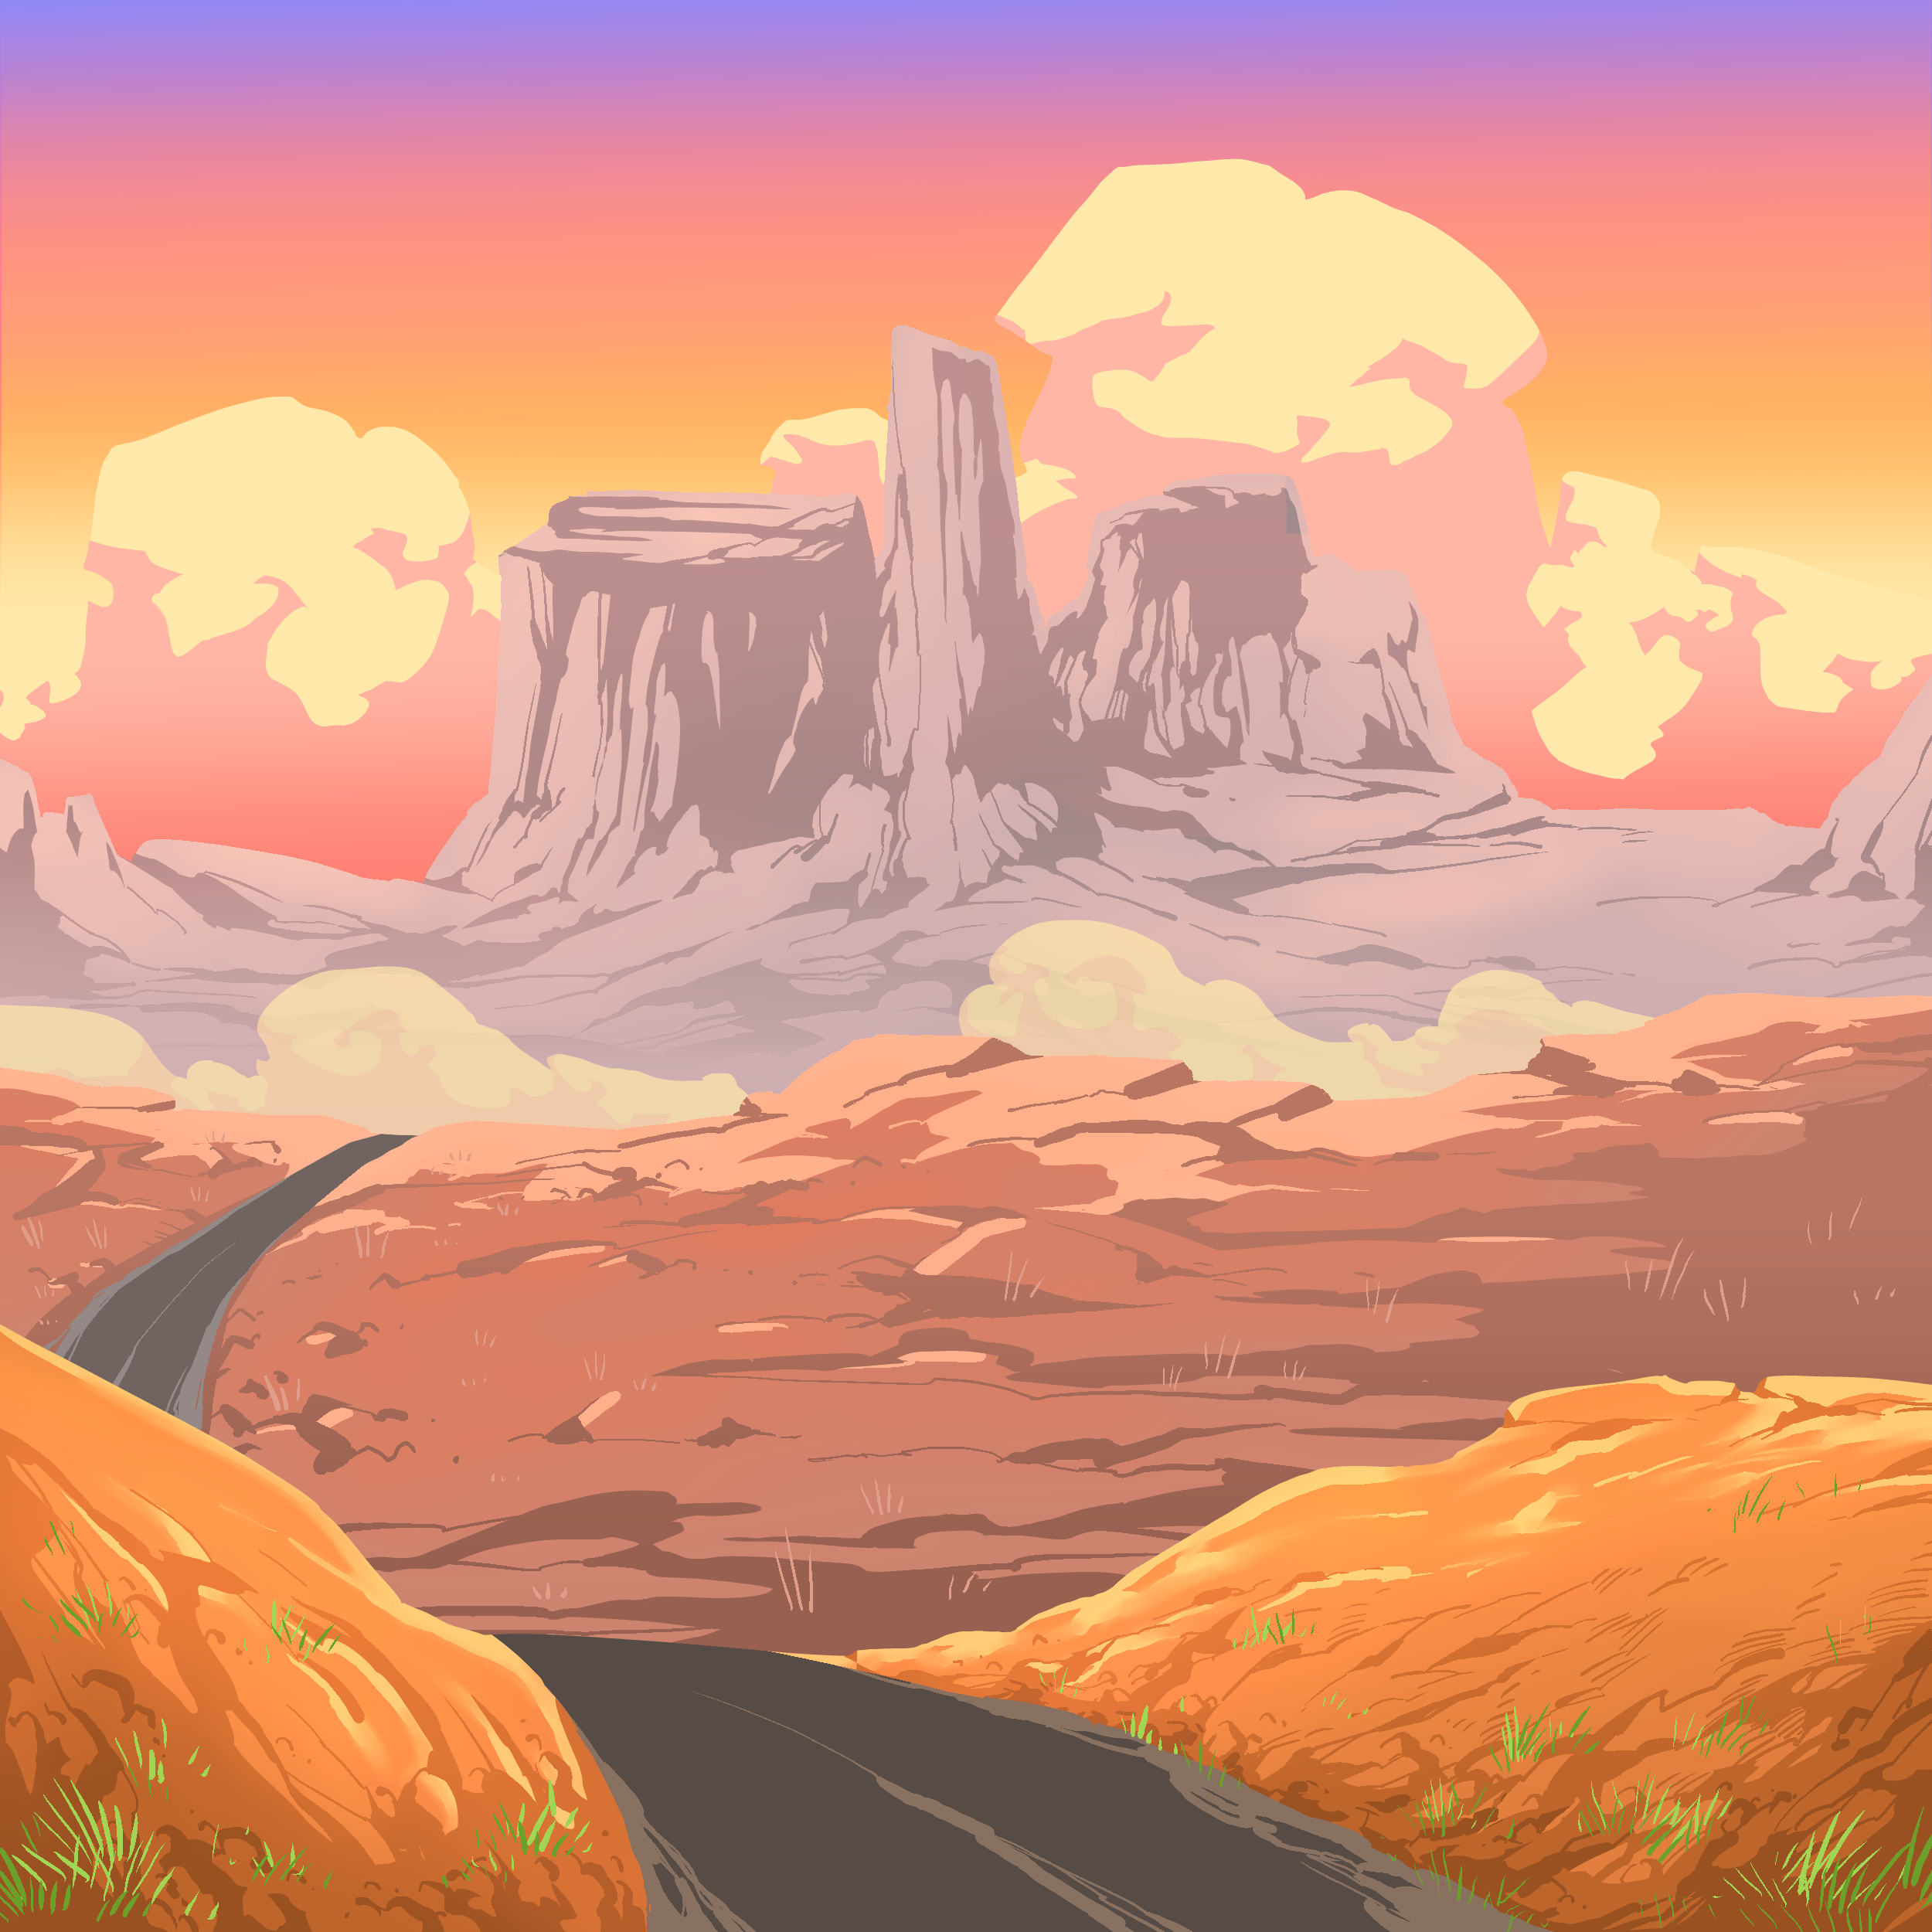

In [13]:
content_image = cv2.imread(content_dir)
style_image = cv2.imread(style_dir)
cv2_imshow(content_image)
cv2_imshow(style_image)

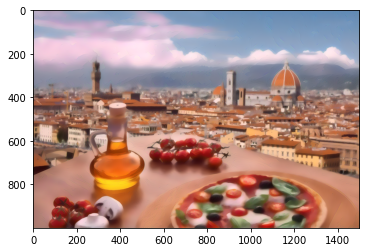

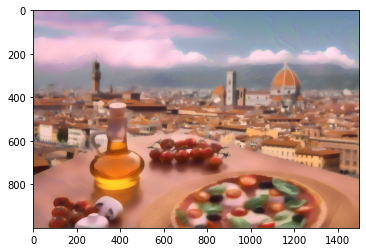

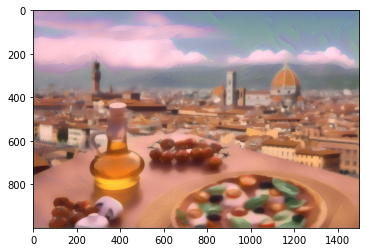

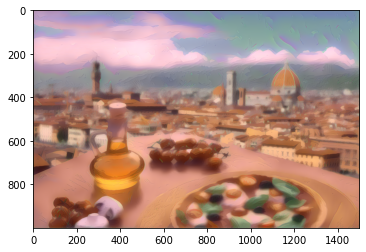

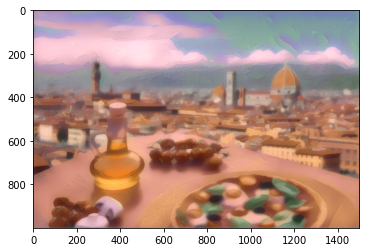

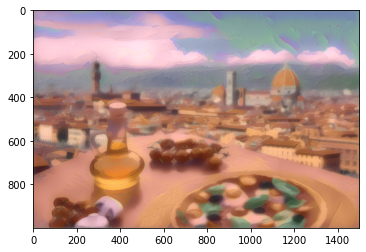

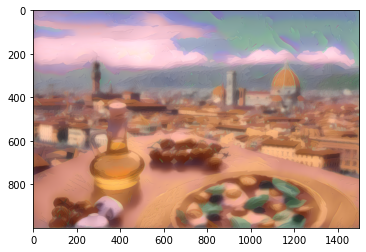

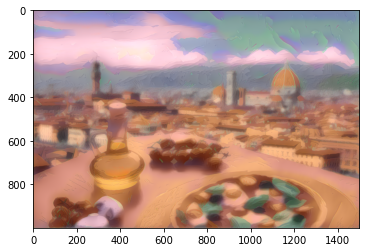

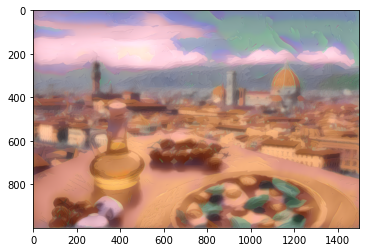

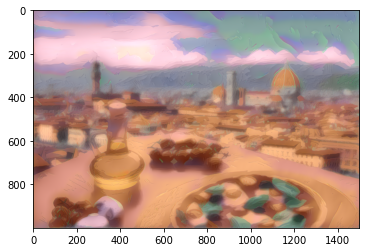

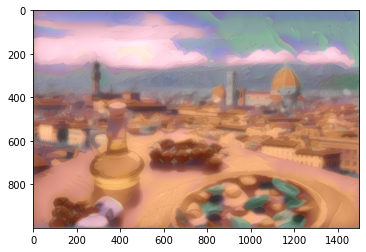

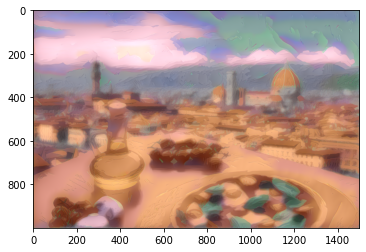

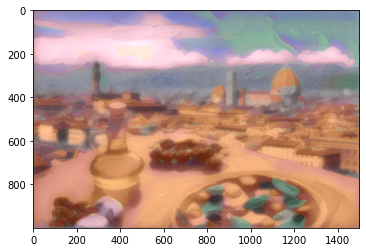

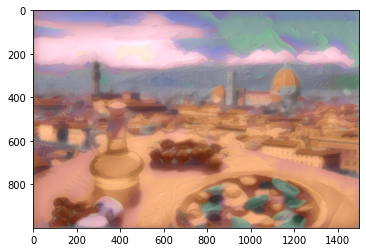

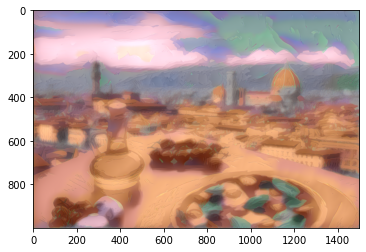

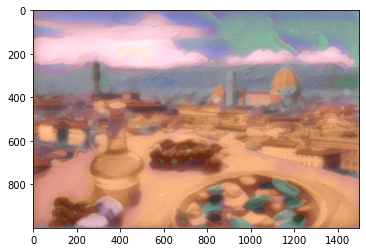

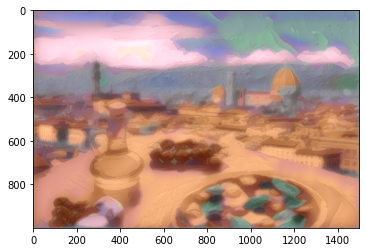

In [ ]:
for i in range(1,epochs+1):
    target_features = model_activations(target,model,layers)
    total_loss = loss_fn(content_features, style_weight_measures)
    
    #if i%10==0:       
        #print("epoch ",i," ", total_loss)
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if i%print_frequency == 0:
        plt.imshow(image_conversion(target,normalizer),label="Epoch "+str(i))
        plt.show()
        plt.imsave(str(i)+'.png',image_conversion(target,normalizer),format='png')
        img = image_conversion(target,normalizer)
        im = Image.fromarray((img * 255).astype(np.uint8))
        im.save("/content/drive/MyDrive/CV/saved/" +str(i)+'.png')
       
